<a href="https://colab.research.google.com/github/manjotpahwa/pyspark-classification/blob/master/Pyspark_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip3 install --user --extra-index-url http://15.206.48.113:80/simple/ --trusted-host 15.206.48.113 --upgrade scrybe

Looking in indexes: https://pypi.org/simple, http://15.206.48.113:80/simple/
User for 15.206.48.113:80: scrybeinstaller
Password: 
Requirement already up-to-date: scrybe in /root/.local/lib/python3.6/site-packages (0.2.7)


In [0]:
# take .scrybeenv file and upload environment variables
!cp ./.scrybeenv ~/.

In [0]:
#!pip uninstall pandas
#!pip uninstall matplotlib

In [0]:
#!pip uninstall pandas
#!pip uninstall matplotlib
import scrybe
import os


scrybe.init("scrybe e2e client testing")

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!pip install pyspark td-pyspark
#!wget -q http://mirrors.viethosting.com/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!wget -q  https://ftp.cc.uoc.gr/mirrors/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
!tar xvf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

In [35]:
#!pip install matplotlib
#!pip install pandas

import scrybe

  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: stable-baselines 2.2.1 requires pandas, which is not installed.
ERROR: seaborn 0.9.0 requires pandas>=0.15.2, which is not installed.
ERROR: plotnine 0.6.0 requires pandas>=0.25.0, which is not installed.
ERROR: pandas-profiling 1.4.1 requires pandas>=0.19, which is not installed.
ERROR: mlxtend 0.14.0 requires pandas>=0.17.1, which is not installed.
ERROR: mizani 0.6.0 requires pandas>=0.25.0, which is not installed.
ERROR: magenta 0.3.19 requires pandas>=0.18.1, which is not installed.
ERROR: fbprophet 0.5 requires pandas>=0.23.4, which is not installed.
ERROR: fastai 1.0.60 requires pandas, which is not installed.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.


In [0]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder \
        .appName('bank-calls') \
        .getOrCreate()

df = spark.read.csv('bank.csv', header=True, inferSchema= True)


In [0]:
df.printSchema()

In [0]:
df.head(n=5)

In [0]:
pd.DataFrame(df.take(5), columns=df.columns)

In [0]:
df.dtypes

In [0]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']


In [0]:
numeric_features_df = df.select(numeric_features)

In [0]:
numeric_pd_data = numeric_features_df.toPandas()

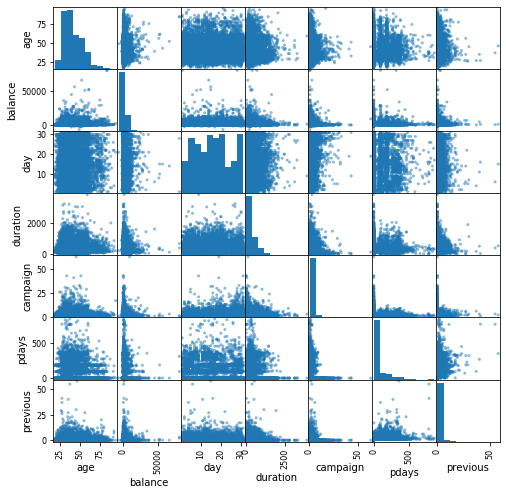

In [10]:
numeric_scatter_matrix = pd.plotting.scatter_matrix(numeric_pd_data, figsize=(8, 8));

In [11]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# setup ML pipeline stages
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [13]:

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [14]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [15]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

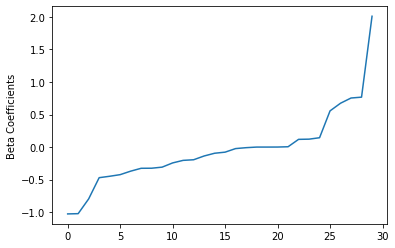

In [17]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

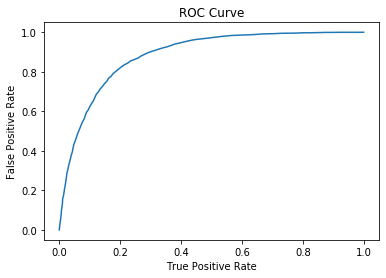

Training set areaUnderROC: 0.8849092421146739


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

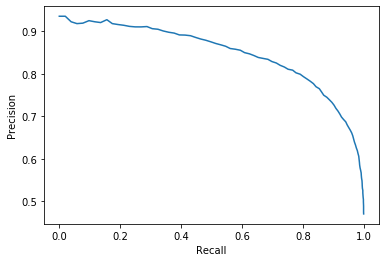

In [19]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [20]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
+---+-------

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8858324614449619


In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 37|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 53|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 32|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 54|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|  [373.0,30.0]|       0.0|[0.92555831265508...|
| 56|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 50|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 47|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 44|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [23]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7910083562522027


In [24]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[14.7346515613874...|       0.0|[0.73673257806937...|
| 40|management|  0.0|[15.8316936379212...|       0.0|[0.79158468189606...|
| 53|management|  0.0|[13.1248353786832...|       0.0|[0.65624176893416...|
| 32|management|  0.0|[15.1326995581545...|       0.0|[0.75663497790772...|
| 54|management|  0.0|[15.2280891979038...|       0.0|[0.76140445989519...|
| 40|management|  0.0|[15.7824525542400...|       0.0|[0.78912262771200...|
| 56|management|  0.0|[17.6081919215903...|       0.0|[0.88040959607951...|
| 50|management|  0.0|[6.28640338633565...|       1.0|[0.31432016931678...|
| 47|management|  0.0|[10.5819457474194...|       0.0|[0.52909728737097...|
| 44|management|  0.0|[9.90327844635457...|       1.0|[0.49516392231772...|
+---+-------

In [25]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8811593016382243


In [26]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[0.57808138910181...|       0.0|[0.76063477260811...|
| 40|management|  0.0|[1.37467582901950...|       0.0|[0.93987672346171...|
| 53|management|  0.0|[-0.0012929624008...|       1.0|[0.49935351915983...|
| 32|management|  0.0|[0.61900313605401...|       0.0|[0.77521678642033...|
| 54|management|  0.0|[0.98157815641818...|       0.0|[0.87687413211579...|
| 40|management|  0.0|[0.96138354833170...|       0.0|[0.87244668327834...|
| 56|management|  0.0|[1.39120025731353...|       0.0|[0.94171733839668...|
| 50|management|  0.0|[-0.6141629093446...|       1.0|[0.22647458093662...|
| 47|management|  0.0|[-0.0439971283470...|       1.0|[0.47801561939801...|
| 44|management|  0.0|[0.26452511568224...|       0.0|[0.62926156628314...|
+---+-------

In [27]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8940728473145346


In [28]:
#@title Default title text
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8981050997838095

In [32]:
scrybe.__version__

NameError: ignored